# LSTM 单步预测

In [2]:
import pandas as pd
df = pd.read_csv('/private/数据/2019-2020sydatahb.csv')
df

date  沈阳过去1小时降水量(毫米)  温度/气温(摄氏度(℃))  相对湿度(百分率)  气压(百帕)  \
0      2019-01-01 23:00:00             0.0           -9.5         81  1016.6   
1      2019-01-02 00:00:00             0.0            2.5         28  1015.7   
2      2019-01-02 01:00:00             0.0           -8.6         54  1018.7   
3      2019-01-02 02:00:00             0.0            1.4         68  1016.6   
4      2019-01-02 03:00:00             0.0          -14.6         86  1020.1   
...                    ...             ...            ...        ...     ...   
17094  2020-12-31 18:00:00             0.0          -11.4         35  1021.3   
17095  2020-12-31 19:00:00             0.0          -12.2         37  1021.7   
17096  2020-12-31 20:00:00             0.0          -12.9         40  1021.8   
17097  2020-12-31 21:00:00             0.0          -14.0         43  1021.8   
17098  2020-12-31 22:00:00             0.0          -14.5         39  1021.7   

       10分钟平均风速(米/秒)  10分钟平均水平能见度(m)  
0                0.8            5872  
1                2.7           21332  
2                0.8            4061  
3                3.0            4373  
4                0.4            2516  
...              ...             ...  
17094            3.0           30000  
17095            3.1           30000  
17096            1.5           30000  
17097            2.3           30000  
17098            3.4           30000  

[17099 rows x 7 columns]

In [3]:
data = df

In [4]:
data.drop(['温度/气温(摄氏度(℃))','相对湿度(百分率)','气压(百帕)','10分钟平均风速(米/秒)','10分钟平均水平能见度(m)'],axis=1,inplace=True)
data['date']=pd.to_datetime(data['date'])
print(data.head())

                 date  沈阳过去1小时降水量(毫米)
0 2019-01-01 23:00:00             0.0
1 2019-01-02 00:00:00             0.0
2 2019-01-02 01:00:00             0.0
3 2019-01-02 02:00:00             0.0
4 2019-01-02 03:00:00             0.0


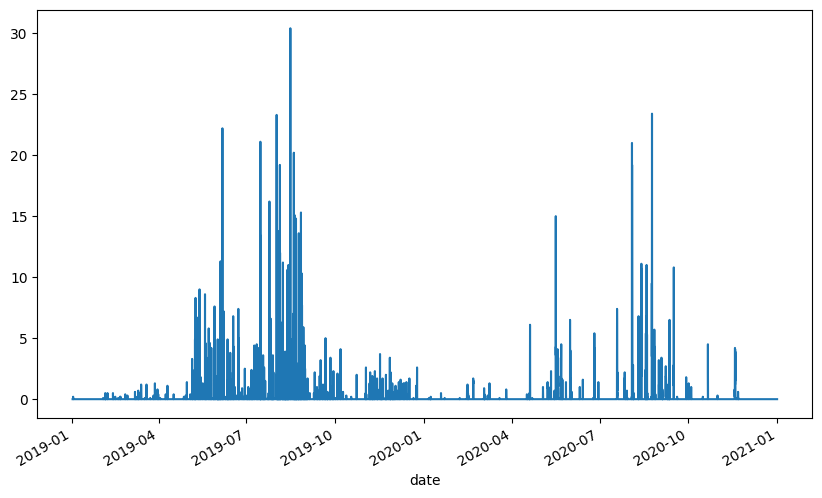

In [5]:
import matplotlib.pyplot as plt
series = data.set_index(['date'], drop=True)
plt.figure(figsize=(10, 6))
series['沈阳过去1小时降水量(毫米)'].plot()
plt.show()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
import math
 
# 数据的差分转换
def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)
 
# 对预测的数据进行逆差分转换
def invert_difference(history,yhat,interval=1):
    return yhat+history[-interval]
 
# 将数据转换为监督学习集，移位后产生的NaN值补0
def timeseries_to_supervised(data,lag=1):
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1,lag+1)]
    columns.append(df)
    df=pd.concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df
 
# 将数据缩放到[-1,1]之间
def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled
 
# 将预测值进行逆缩放，使用之前训练好的缩放器，x为一维数组，y为实数
def invert_scale(scaler,X,y):
    # 将X,y转换为一个list列表
    new_row=[x for x in X]+[y]
    # 将列表转换为数组
    array=np.array(new_row)
    # 将数组重构成一个形状为[1,2]的二维数组->[[10,12]]
    array=array.reshape(1,len(array))
    # 逆缩放输入的形状为[1,2]，输出形状也是如此
    invert=scaler.inverse_transform(array)
    # 只需要返回y值即可
    return invert[0,-1]
 
# 构建一个LSTM模型
def fit_lstm(train,batch_size,nb_epoch,neurons):
    # 将数据对中的x和y分开
    X,y=train[:,0:-1],train[:,-1]
    # 将2D数据拼接成3D数据，形状为[N*1*1]
    X=X.reshape(X.shape[0],1,X.shape[1])
 
    model=Sequential()
    model.add(LSTM(neurons,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(1))
 
    model.compile(loss='mean_squared_error',optimizer='adam')
    for i in range(nb_epoch):
        # shuffle是不混淆数据顺序
        his=model.fit(X,y,batch_size=batch_size,verbose=1,shuffle=False)
        # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
        model.reset_states()
    return model
 
# 开始单步预测
import tensorflow as tf  # 确保导入tensorflow

def forecast_lstm(model, batch_size, X):
    # 确保X是一个Tensor
    X = tf.convert_to_tensor(X, dtype=tf.float32)  # 添加这行代码来转换X
    X = tf.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

 
# 读取数据，将日期和时间列合并，其他列删除，合并后的列转换为时间格式，设为索引
data['date']=pd.to_datetime(data['date'])
series=data.set_index(['date'],drop=True)
 
# 将原数据转换为二维数组形式，例如：
# [[4.6838],[4.6882],[4.7048]]
raw_value=series.values
# 将数据进行差分转换，例如[[4.6838],[4.6882],[4.7048]]转换为[[4.6882-4.6838],[4.7048-4.6882]]
diff_value=difference(raw_value,1)
#
# 将序列形式的数据转换为监督学习集形式，例如[[10],[11],[12],[13]]
# 在此将其转换为监督学习集形式：[[0,10],[10,11],[11,12],[12,13]]，
# 即前一个数作为输入，后一个数作为对应的输出
supervised=timeseries_to_supervised(diff_value,1)
supervised_value=supervised.values
 
# 将数据集分割为训练集和测试集，设置后1000个数据为测试集
testNum=3000
train,test=supervised_value[:-testNum],supervised_value[-testNum:]
 
# 将训练集和测试集都缩放到[-1,1]之间
scaler,train_scaled,test_scaled=scale(train,test)
 
# 构建一个LSTM模型并训练，样本数为1，训练次数为5，LSTM层神经元个数为4
lstm_model=fit_lstm(train_scaled,1,1,4)
# 遍历测试集，对数据进行单步预测
predictions=list()
for i in range(len(test_scaled)):
    # 将测试集拆分为X和y
    X,y=test[i,0:-1],test[i,-1]
    # 将训练好的模型、测试数据传入预测函数中
    yhat=forecast_lstm(lstm_model,1,X)
    # 将预测值进行逆缩放
    yhat=invert_scale(scaler,X,yhat)
    # 对预测的y值进行逆差分
    yhat=invert_difference(raw_value,yhat,len(test_scaled)+1-i)
    # 存储正在预测的y值
    predictions.append(yhat)
 
# 计算方差
rmse=mean_squared_error(raw_value[-testNum:],predictions)
print("Test RMSE:",rmse)
plt.plot(raw_value[-testNum:])
plt.plot(predictions)
plt.legend(['true','pred'])
plt.show()

2024-03-13 16:41:23.605941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 16:41:23.607670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 16:41:23.608767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14098/14098 [==============================] - 69s 5ms/step - loss: 0.0014


ValueError: in user code:

    File "/opt/conda/envs/Tensorflow-2.12.0/lib/python3.8/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/envs/Tensorflow-2.12.0/lib/python3.8/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/Tensorflow-2.12.0/lib/python3.8/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/envs/Tensorflow-2.12.0/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/opt/conda/envs/Tensorflow-2.12.0/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/envs/Tensorflow-2.12.0/lib/python3.8/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (1,)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(1,), dtype=int32)
      • training=False
      • mask=None


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 加载数据
df = pd.read_csv('/private/数据/2019-2020sydatahb.csv')  # 请替换为你的文件路径
data = df['沈阳过去1小时降水量(毫米)'].values.reshape(-1, 1)

# 数据缩放到[-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 将序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 输入序列 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # 将所有的拼接在一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 丢弃含有NaN值的行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_hours = 64  # 使用3小时的数据预测下一个小时
n_features = 1  # 特征数量，这里只有降水量一个特征
reframed = series_to_supervised(data_scaled, n_hours, 1)

# 分割为训练集和测试集
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 分割为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 重塑成3D形状 [样本, 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')



2024-03-13 17:26:37.016874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 17:26:37.018706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 17:26:37.019809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-03-13 17:24:54.708016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 17:24:54.709742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 17:24:54.710839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 - 3s - loss: 0.1690 - val_loss: 0.0090 - 3s/epoch - 17ms/step
Epoch 2/50
190/190 - 1s - loss: 0.0124 - val_loss: 0.0083 - 1s/epoch - 6ms/step
Epoch 3/50
190/190 - 1s - loss: 0.0114 - val_loss: 0.0074 - 1s/epoch - 6ms/step
Epoch 4/50
190/190 - 1s - loss: 0.0121 - val_loss: 0.0160 - 1s/epoch - 6ms/step
Epoch 5/50
190/190 - 1s - loss: 0.0119 - val_loss: 0.0101 - 1s/epoch - 6ms/step
Epoch 6/50
190/190 - 1s - loss: 0.0114 - val_loss: 0.0094 - 1s/epoch - 6ms/step
Epoch 7/50
190/190 - 1s - loss: 0.0113 - val_loss: 0.0128 - 1s/epoch - 6ms/step
Epoch 8/50
190/190 - 1s - loss: 0.0114 - val_loss: 0.0149 - 1s/epoch - 6ms/step
Epoch 9/50
190/190 - 1s - loss: 0.0117 - val_loss: 0.0157 - 1s/epoch - 6ms/step
Epoch 10/50
190/190 - 1s - loss: 0.0111 - val_loss: 0.0129 - 1s/epoch - 6ms/step
Epoch 11/50
190/190 - 1s - loss: 0.0112 - val_loss: 0.0173 - 1s/epoch - 6ms/step
Epoch 12/50
190/190 - 1s - loss: 0.0116 - val_loss: 0.0172 - 1s/epoch - 6ms/step
Epoch 13/50
190/190 - 1s - loss: 0.0112 - val_l

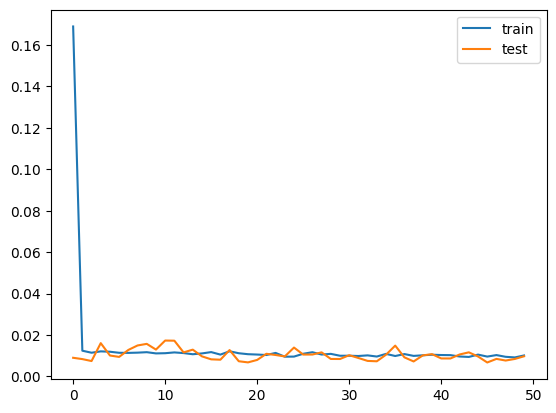

 22/107 [=====>........................] - ETA: 0s 

2024-03-13 17:25:52.208728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 17:25:52.210496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 17:25:52.211650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

107/107 [==============================] - 1s 3ms/step
Test RMSE: 0.734


In [10]:
# 模型训练
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 做出预测
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], n_hours*n_features))

# 逆缩放预测值
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# 逆缩放真实值
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_X_reshaped[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


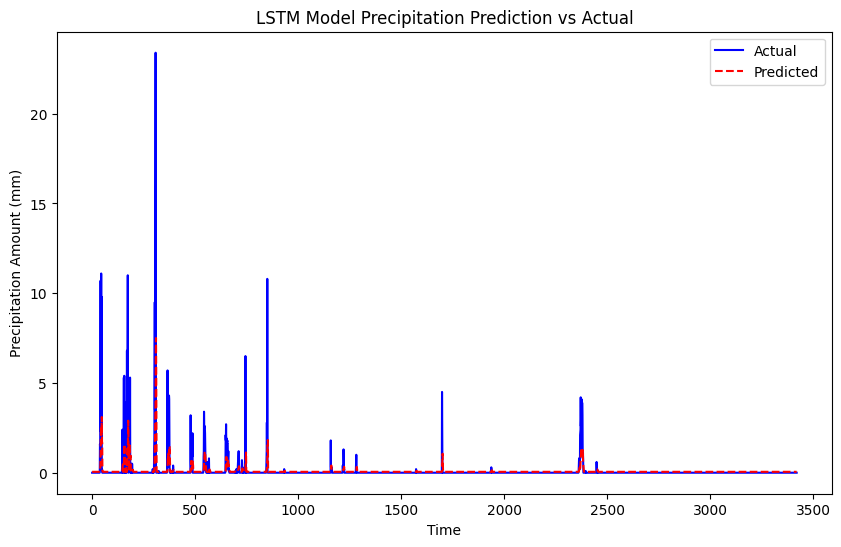

In [12]:
import matplotlib.pyplot as plt

# 绘制实际降水量与预测降水量的对比图
plt.figure(figsize=(10, 6))
plt.plot(inv_y, label='Actual', color='blue')  # 实际降水量
plt.plot(inv_yhat, label='Predicted', color='red', linestyle='--')  # 预测降水量
plt.title('LSTM Model Precipitation Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Precipitation Amount (mm)')
plt.legend()
plt.show()


In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np


#转成有监督数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    #数据序列(也将就是input) input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        #预测数据（input对应的输出值） forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    #拼接 put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # 删除值为NAN的行 drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


##数据预处理 load dataset
dataset = read_csv('data_set/pollution.csv', header=0, index_col=0)
values = dataset.values
#标签编码 integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
#保证为float ensure all data is float
values = values.astype('float32')
#归一化 normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#转成有监督数据 frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
#删除不预测的列 drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

#数据准备
#把数据分为训练数据和测试数据 split into train and test sets
values = reframed.values
#拿一年的时间长度训练
n_train_hours = 365 * 24
#划分训练数据和测试数据
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#拆分输入输出 split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#reshape输入为LSTM的输入格式 reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print ('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

##模型定义 design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#模型训练 fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=36, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
#输出 plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#进行预测 make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#预测数据逆缩放 invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
inv_yhat = np.array(inv_yhat)
#真实数据逆缩放 invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

#画出真实数据和预测数据
pyplot.plot(inv_yhat,label='prediction')
pyplot.plot(inv_y,label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

